# Sort candidate pulse sequences

From the job output, keep only the lines that contain the text "candidate pulse sequence" (can do `cat rl_pulse... | grep "candidate pulse sequence"`) or use regex to delete all lines that don't contain candidate sequences via `^((?!candidate pulse sequence).)*$`.

In [1]:
import sys
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [2]:
path = '../../data/2021-04/20210403-122814/'

In [3]:
candidates = []
with open(os.path.join(path, 'candidates.txt')) as file:
    for line in file:
        candidates.append(line)

In [4]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print('exception caught')
        # print(c)

exception caught
exception caught


In [5]:
len(c2)

12180

In [6]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

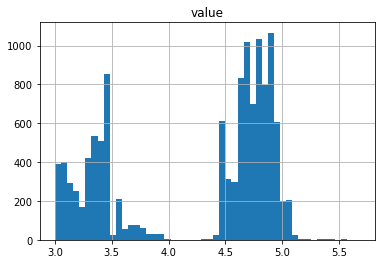

In [7]:
df.hist('value', bins=50)

In [8]:
df.sort_values('value', ascending=False, inplace=True)
# df

In [9]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [10]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [11]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [12]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [13]:
df.head()

,timestamp,sequence,last_pulse,value,full_sequence
1522,2021-04-04 03:33:39.667124,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, ...",4,5.677306,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, ..."
8819,2021-04-04 10:01:56.920521,"[4, 3, 2, 3, 3, 2, 3, 4, 1, 4, 4, 1, 4, 3, 2, ...",2,5.572633,"[4, 3, 2, 3, 3, 2, 3, 4, 1, 4, 4, 1, 4, 3, 2, ..."
9978,2021-04-04 10:51:55.477179,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 4, 1, 4, ...",1,5.541490,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 4, 1, 4, ..."
10050,2021-04-04 10:54:47.683875,"[4, 3, 2, 3, 3, 2, 3, 4, 1, 4, 4, 1, 4, 3, 2, ...",2,5.531439,"[4, 3, 2, 3, 3, 2, 3, 4, 1, 4, 4, 1, 4, 3, 2, ..."
4058,2021-04-04 06:26:16.658228,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, ...",4,5.522234,"[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, ..."


In [14]:
df.to_csv(os.path.join(path, 'candidates_sorted.csv'))

In [15]:
df.head().to_csv(os.path.join(path, 'candidates_sorted_top.csv'))

In [16]:
print(df.iloc[0]['full_sequence'])

[2, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, 1, 4, 1, 3, 1, 3, 3, 1, 3, 4, 2, 4, 4, 2, 4, 2, 2, 3, 2, 2, 3, 4, 1, 4, 4, 1, 4, 2, 2, 4, 2, 2, 4]


## Set up spin system

In [ ]:
import qutip as qt
import multiprocessing as mp
sys.path.append('..')
import pulse_sequences as ps
importlib.reload(ps)

In [67]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 50

In [68]:
X, Y, Z = ps.get_collective_spin(N)

In [69]:
Hsys_ensemble = []
for _ in range(ensemble_size):
    Hsys_ensemble.append(ps.get_Hsys(N=N, dipolar_strength=dipolar_strength))
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(
        H, X, Y, Z, pulse_width=pulse_width, delay=delay, rot_error=rot
    ))

In [70]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Check candidates

In [254]:
# read from file if not loaded above
# df = pd.read_csv('../../data/2021-02/20210219-082529/candidates_sorted.csv')

In [83]:
# unique_sequences = df['full_sequence'].map(lambda x: tuple(x)).unique()
# unique_sequences = [list(i) for i in unique_sequences]
# len(unique_sequences)

In [86]:
N_seq = 25
fidelities = np.zeros(N_seq)
with mp.Pool(4) as p:
    fidelities = p.starmap(ps.get_mean_fidelity,
                           [(c, Utarget, pulses_ensemble)
                            for c in df['full_sequence'].iloc[:N_seq] #unique_sequences[:N_seq]
                           ])
fidelities = np.array(fidelities)

Text(0, 0.5, 'reward estimate (from job)')

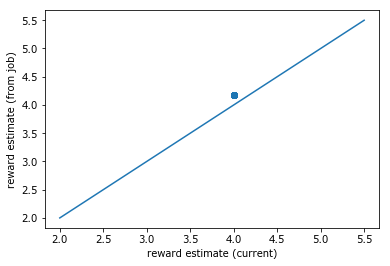

In [87]:
# confirm that calculated rewards match what was calculated from the job
plt.scatter(-np.log10(1 - fidelities), df['value'].iloc[:N_seq])
plt.plot([2, 5.5], [2, 5.5])
plt.xlabel('reward estimate (current)')
plt.ylabel('reward estimate (from job)')

In [88]:
np.argmin(1 - fidelities), (1 - fidelities).min(), -np.log10((1 - fidelities).min())

(0, 9.850436767422366e-05, 4.0065445124997465)

In [90]:
df.iloc[0]

timestamp                  2021-03-06 23:58:53.951124
sequence            [1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4]
last_pulse                                          4
value                                         4.18071
full_sequence    [1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4, 4]
Name: 33942, dtype: object

In [91]:
print(df['full_sequence'].iloc[0])

[1, 3, 3, 1, 3, 3, 1, 4, 4, 1, 4, 4]


In [49]:
df.iloc[0:2]

,timestamp,sequence,last_pulse,value,full_sequence
2429,2021-03-01 12:38:41.265390,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ...",1,3.920358,"[3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 1, 0, 3, 0, ..."
662,2021-03-01 01:15:00.418460,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ...",0,3.851370,"[3, 0, 0, 1, 3, 3, 0, 2, 0, 1, 1, 1, 3, 3, 3, ..."


In [271]:
# plt.hist(1 - fidelities, bins=30)
# # fit exponential distribution
# X = np.linspace(0, .1, 100)
# Y = np.exp(-1 / np.mean(1 - fidelities) * X)
# plt.plot(X, Y * 4)

## Format and print pulse sequence

In [1]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [10]:
sequence_string = [names[i] for i in ps.az48_3]

delta = 48 / 8
for i in range(8):
    print('$', ', '.join(sequence_string[int(i*delta):int((i+1)*delta)]), '$')

$ -X, \tau, Y, \tau, Y, \tau, X, \tau, Y, \tau, Y, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ -Y, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau $
$ -X, \tau, -X, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau $
$ Y, \tau, -Y, \tau, X, \tau, -Y, \tau, -Y, \tau, X, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ -Y, \tau, -X, \tau, -X, \tau, -Y, \tau, -X, \tau, -X, \tau $


$ -X, \tau, Y, \tau, Y, \tau, X, \tau, Y, \tau, Y, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau $
$ Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau $
$ -X, \tau, -X, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, Y, \tau, -Y, \tau, X, \tau, -Y, \tau, -Y, \tau, X, \tau $
$ -Y, \tau, X, \tau, X, \tau, -Y, \tau, X, \tau, X, \tau, -Y, \tau, -X, \tau, -X, \tau, -Y, \tau, -X, \tau, -X, \tau $

Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $